# Using AI based diffusive size factors for extracted networks

This notebook illustrates the use of the deep learning based diffusive conductance algorithm decribed [here](https://doi.org/10.1016/j.cageo.2022.105086). PoreSpy's `diffusive_size_factor_AI` includes the steps for predicting the diffusive size factors of the conduit images. Note that the diffusive conductance of the conduits can be then calculated by multiplying the size factor by diffusivity of the phase. The function takes in the images of segmented porous medium and returns an array of diffusive size factors for all conduits in the image. Therefore, the framework can be applied to both one conduit image as well as a segmented image of porous medium:

<img src="https://user-images.githubusercontent.com/43128873/116145783-bd458380-a6ab-11eb-8103-fb9a93f0599c.png" alt="PS_dl" width="700"/>

# Trained model and supplementary materials
To use the `diffusive_size_factor_AI`, the trained model, and training data distribution are required. The AI model files and additional files used in this example are available [here](https://dl.dropboxusercontent.com/s/jrq82twl0vwedy4/AI_example_data.rar?dl=0). The folder contains following files:

- Trained model weights: This file includes only weights of the deep learning layers. To use this file, the Resnet50 model structure must be built first.
- Trained data distribution: This file will be used in denormalizing predicted values based on normalized transform applied on training data. The denormalizing step is included in `diffusive_size_factor_AI` method.
- Finite difference diffusive conductance: This file is used in this example to compare the prediction results with finite difference method for segmented regions
- Pair of regions: This file is used in this example to compare the prediction results with finite difference method for a pair of regions

Let's download the `tensorflow` files required to run this notebook:

In [1]:
try:
    import tensorflow as tf
except ImportError:
    !pip install tensorflow

try:
    import sklearn
except ImportError:
    !pip install scikit-learn

import os

if not os.path.exists("sf-model-lib"):
    !git clone https://github.com/PMEAL/sf-model-lib

Also, since the model weights have been stored in chunks, they need to be recombined first:

In [2]:
import importlib
h5tools = importlib.import_module("sf-model-lib.h5tools")
DIR_WEIGHTS = "sf-model-lib/diffusion"
fname_in = [f"{DIR_WEIGHTS}/model_weights_part{j}.h5" for j in [0, 1]]
h5tools.combine(fname_in, fname_out=f"{DIR_WEIGHTS}/model_weights.h5")

Note that to use `diffusive_size_factor_AI`, [Scikit-learn](https://scikit-learn.org/stable/index.html?msclkid=9e175644bb2511ecb89dded5ce21b89f) and [Tensorflow](https://www.tensorflow.org/?msclkid=a5a214bdbb2511ecadd52383bd2650c1) must be installed. Import necessary packages and the AI model: 

In [3]:
import os
import warnings

import h5py
import numpy as np
import openpnm as op
import porespy as ps
import scipy as sp
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score

ps.visualization.set_mpl_style()
warnings.filterwarnings("ignore")
path = "./sf-model-lib/diffusion"
path_train = os.path.join(path, 'g_train_original.hdf5')
path_weights = os.path.join(path, 'model_weights.h5')
g_train = h5py.File(path_train, 'r')['g_train'][()]
model = ps.networks.create_model()
model.load_weights(path_weights)

## Create test image

We can create a 3D image using PoreSpy's `poly_disperese_spheres` generator:

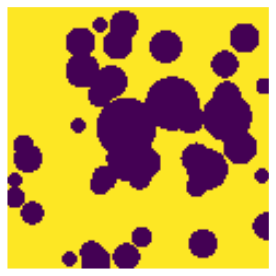

In [4]:
np.random.seed(17)
shape = [120, 120, 120]
dist = sp.stats.norm(loc=7, scale=5)
im = ps.generators.polydisperse_spheres(shape=shape,
                                        porosity=0.7,
                                        dist=dist,
                                        r_min=7)
fig, ax = plt.subplots(1, 1, figsize=[4, 4])
ax.imshow(im[:, :, 20], origin='lower', interpolation='none')
ax.axis(False);

## Extract the network

We then extract the pore network of the porous medium image using PoreSpy's `snow2` algorithm. `snow2` returns the segmented image of the porous medium as well as extracted network data.

In [5]:
snow = ps.networks.snow2(im, boundary_width=0, parallelization=None)
regions = snow.regions
net = snow.network

0it [00:00, ?it/s]

Extracting pore and throat properties:   0%|          | 0/199 [00:00<?, ?it/s]

## Apply diffusive_size_factor_AI

AI_based diffusive size factors of conduits in the extracted network can then be calculated applying `diffusive_size_factor_AI` on the segmented regions. We can then define `throat.diffusive_size_factor_AI` property and assign the predicted size_factor to this property.

In [6]:
conns = net['throat.conns']
size_factors = ps.networks.diffusive_size_factor_AI(regions,
                                                    model=model,
                                                    g_train=g_train,
                                                    throat_conns=conns)
net['throat.diffusive_size_factor_AI'] = size_factors

Preparing images tensor:   0%|          | 0/744 [00:00<?, ?it/s]

The resulting network can then be imported to OpenPNM for later use such as diffusive mass transport simulations problems. Let's visualize the network:

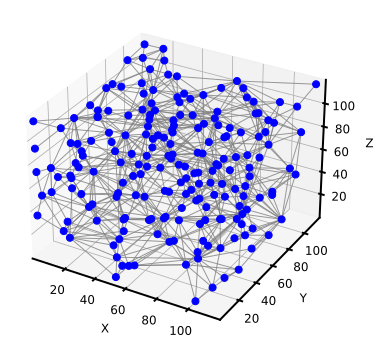

In [7]:
try:
    pn, geo = op.io.PoreSpy.import_data(net)
except AttributeError:
    pn, geo = op.io.from_porespy(net)
fig, ax = plt.subplots(1, 1, figsize=[5, 5])
ax = op.topotools.plot_connections(network=pn, alpha=0.8, color='grey', ax=ax)
ax = op.topotools.plot_coordinates(network=pn, ax=ax, color='b', markersize=50)

## Compare with finite difference method

Now that the extracted network includes AI_based diffusive size factor data, we can use the network to compare the accuracy of `diffusive_size_factor_AI`, shape factor method,and geometry method (no shape factor) in contrast to finite difference method. Assuming a generic phase with diffusivity of 1, the diffusive conductance of the conduits will be equal to their diffusive size factors. The diffusive conductance of the conduits can be calculated using OpenPNM's generic_diffusive method. The diffusive conductance of the conduits using shape factor based method assuming cones and cylinders shapes for pores and throats can be calculated as follows:

In [8]:
geo.add_model(propname='throat.diffusive_size_factor',
              model=op.models.geometry.diffusive_size_factors.cones_and_cylinders)
try:
    phase = op.phases.GenericPhase(network=pn)
except AttributeError:
    phase = op.phase.GenericPhase(network=pn)
phys = op.physics.GenericPhysics(network=pn, phase=phase, geometry=geo)
phase['pore.diffusivity'] = 1
phase['throat.diffusivity'] = 1
phys.add_model(propname='throat.diffusive_conductance',
               model=op.models.physics.diffusive_conductance.generic_diffusive)
g_SF = phys['throat.diffusive_conductance']

To find the diffusive conductance of the conduit using geometry method (no shape factor) we assume cylindrical pores and throats:

In [9]:
cn = pn.conns
L1, Lt, L2 = geo['pore.diameter'][
    cn[:, 0]] / 2, geo['throat.length'], geo['pore.diameter'][cn[:, 1]] / 2
D1, Dt, D2 = geo['pore.diameter'][
    cn[:, 0]], geo['throat.diameter'], geo['pore.diameter'][cn[:, 1]]
A1, At, A2 = np.pi * D1**2 / 4, np.pi * Dt**2 / 4, np.pi * D2**2 / 4
g_Geo = 1 / (L1 / A1 + L2 / A2 + Lt / At)

The diffusive conductance of the conduit using AI-based method:

In [10]:
phys.add_model(propname='throat.diffusive_conductance',
               model=op.models.physics.diffusive_conductance.generic_diffusive,
               size_factors='throat.diffusive_size_factor_AI')
g_AI = phys['throat.diffusive_conductance']

Now let's compare the diffusive conductance calculated from geometry-based method, shape factor based-method, and AI-based method with reference finite difference method. he reference diffusive conductance values for comparisons are calculated using finite difference method explained [here](https://doi.org/10.1016/j.cageo.2022.105086) and saved in the example data folder.

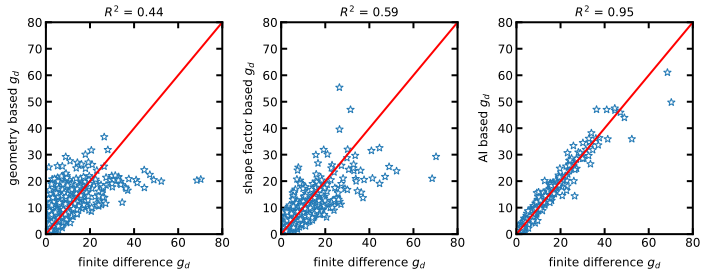

In [11]:
fname = os.path.join(path, 'g_finite_difference120-phi7.hdf5')
g_FD = h5py.File(fname, 'r')['g_finite_difference'][()]

fig, ax = plt.subplots(1, 3, figsize=[10, 4])

ax[0].plot(g_FD, g_Geo, '*', [0, 80], [0, 80], 'r')
ax[0].set_xlim([0, 80])
ax[0].set_ylim([0, 80])
ax[0].set_xlabel('finite difference $g_d$')
ax[0].set_ylabel('geometry based $g_d$')
ax[0].set_title('$R^2$ = ' + str(np.round(r2_score(g_FD, g_Geo), 2)))

ax[1].plot(g_FD, g_SF, '*', [0, 80], [0, 80], 'r')
ax[1].set_xlim([0, 80])
ax[1].set_ylim([0, 80])
ax[1].set_xlabel('finite difference $g_d$')
ax[1].set_ylabel('shape factor based $g_d$')
ax[1].set_title('$R^2$ = ' + str(np.round(r2_score(g_FD, g_SF), 2)))

ax[2].plot(g_FD, g_AI, '*', [0, 80], [0, 80], 'r')
ax[2].set_xlim([0, 80])
ax[2].set_ylim([0, 80])
ax[2].set_xlabel('finite difference $g_d$')
ax[2].set_ylabel('AI based $g_d$')
ax[2].set_title(r'$R^2$ = ' + str(np.round(r2_score(g_FD, g_AI), 2)));

As shown in the scatter plots, the AI-based diffusive conductance method predicts the conductance values with a higher accuracy than geometry-based and shape factor-based methods. A comprehensive comparison between these methods for a large dataset can be found [here](https://doi.org/10.1016/j.cageo.2022.105086). 